In [1]:
using Gen
using Distributions
using Random
using Plots


In [2]:
using Gen

@gen function polya_urn_model_complete(T::Int, R0::Int, B0::Int)
    alpha_idx ~ categorical(fill(1.0/11.0, 11))  # values 1..11
    alpha = alpha_idx - 1

    # Urn state
    R = R0
    B = B0

    draws = Int[]

    for t in 1:T
        p_red = R / (R + B)

        d = @trace(bernoulli(p_red), (:draw, t))
        push!(draws, d)

        if d == 1
            R += alpha
        else
            B += alpha
        end
    end

    return draws
end


DynamicDSLFunction{Any}(Dict{Symbol, Any}(), Dict{Symbol, Any}(), Type[Int64, Int64, Int64], false, Union{Nothing, Some{Any}}[nothing, nothing, nothing], Main.var"##polya_urn_model_complete#277", Bool[0, 0, 0], false)

In [4]:
Random.seed!(69)

T  = 25
R0 = 5
B0 = 5

(trace, _) = generate(polya_urn_model_complete, (T, R0, B0))

println("Observations (draws; 1=red, 0=blue):")
println(get_retval(trace))

println("\nLatent parameter:")
println("alpha = ", trace[:alpha_idx] - 1)


Observations (draws; 1=red, 0=blue):
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]

Latent parameter:
alpha = 5


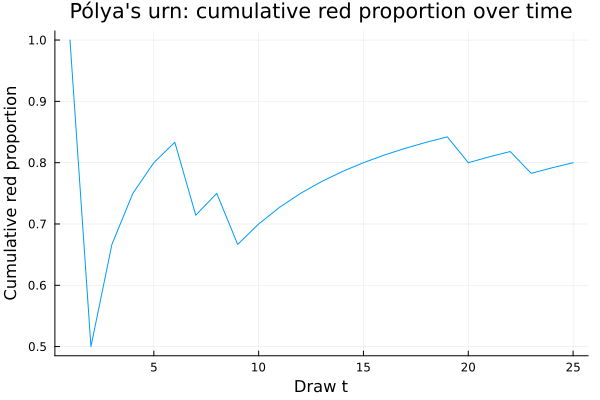

In [5]:
draws = get_retval(trace)
T = length(draws)

cum_red = cumsum(draws)
cum_prop = cum_red ./ collect(1:T)

plot(
    1:T,
    cum_prop,
    xlabel = "Draw t",
    ylabel = "Cumulative red proportion",
    title = "Pólya's urn: cumulative red proportion over time",
    legend = false
)


In [6]:

obs_draws = get_retval(trace)   
T = length(obs_draws)

observations = choicemap()
for t in 1:T
    observations[(:draw, t)] = obs_draws[t]
end

println("Conditioning on $(T) observed draws.")


Conditioning on 25 observed draws.


In [7]:
# Importance Sampling 
function importance_sampling_alpha(num_particles::Int, T::Int, R0::Int, B0::Int, observations)
    alphas = Int[]
    logw   = Float64[]

    for i in 1:num_particles
        tr, lw = generate(polya_urn_model_complete, (T, R0, B0), observations)
        push!(alphas, tr[:alpha_idx] - 1)
        push!(logw, lw)
    end
    
    m = maximum(logw)
    w = exp.(logw .- m)
    w ./= sum(w)

    return alphas, w, logw
end

N = 2000
alphas_is, w_is, logw_is = importance_sampling_alpha(N, T, R0, B0, observations)

post_is = zeros(11)
for (a, w) in zip(alphas_is, w_is)
    post_is[a+1] += w
end

println("IS posterior mean alpha ≈ ", sum((0:10) .* post_is))


IS posterior mean alpha ≈ 5.3367050319477265


In [8]:
# MH
function propose_alpha_rw(alpha_idx::Int)
    step = rand([-1, 1])
    new_idx = alpha_idx + step
    return clamp(new_idx, 1, 11)
end

function mh_alpha(num_steps::Int, T::Int, R0::Int, B0::Int, observations; init_alpha_idx::Int=6)
    init_cm = choicemap()
    init_cm[:alpha_idx] = init_alpha_idx
    tr, lw = generate(polya_urn_model_complete, (T, R0, B0), merge(init_cm, observations))

    samples = Int[]
    logps   = Float64[]
    accepts = 0

    for s in 1:num_steps
        old_idx = tr[:alpha_idx]
        new_idx = propose_alpha_rw(old_idx)

        proposal = choicemap()
        proposal[:alpha_idx] = new_idx

        new_tr, new_lw, _, _ = update(tr, (T, R0, B0), (NoChange(), NoChange(), NoChange()), proposal)

        if log(rand()) < (new_lw - lw)
            tr = new_tr
            lw = new_lw
            accepts += 1
        end

        push!(samples, tr[:alpha_idx] - 1)
        push!(logps, lw)
    end

    return samples, accepts / num_steps
end

mh_samples, acc_rate = mh_alpha(5000, T, R0, B0, observations; init_alpha_idx=6)
println("MH acceptance rate ≈ ", acc_rate)

post_mh = zeros(11)
for a in mh_samples
    post_mh[a+1] += 1
end
post_mh ./= sum(post_mh)

println("MH posterior mean alpha ≈ ", sum((0:10) .* post_mh))


MH acceptance rate ≈ 0.858
MH posterior mean alpha ≈ 4.978800000000001


In [9]:

function loglik_polya(alpha::Int, draws::Vector{Int}, R0::Int, B0::Int)
    R = R0
    B = B0
    ll = 0.0

    for d in draws
        p_red = R / (R + B)
        ll += Distributions.logpdf(Distributions.Bernoulli(p_red), d)

        if d == 1
            R += alpha
        else
            B += alpha
        end
    end
    return ll
end


loglik_polya (generic function with 1 method)

In [10]:
logprior = fill(-log(11.0), 11)

logpost = similar(logprior)
for a in 0:10
    logpost[a+1] = logprior[a+1] + loglik_polya(a, obs_draws, R0, B0)
end

m = maximum(logpost)
p = exp.(logpost .- m)
p ./= sum(p)

println("Exact posterior mean alpha ≈ ", sum((0:10) .* p))
println("Exact MAP alpha = ", argmax(p) - 1)



Exact posterior mean alpha ≈ 5.443039151602847
Exact MAP alpha = 4
